In [2]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [3]:
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos
Exemple pour la région centre val de Loire.  
Récupération des codes_bss dans la liste des départements pour les fichiers dispos

In [108]:
region = "PDL"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = f_requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


## Construction d'un dataframe

In [109]:
directory = '../data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')
data

,05068X0028_SP010,04514X0018_01,04808X0027_N11,03234X0535_PZ21,03237X0043_PZ31,04555X0093_F1,03938X0034_F1,04552X0069_F1,05078X0040_PZN1,04854X0188_P1,...,03928X0026_PZ,03932X0046_PZ,03936X0056_PZ,03925X0017_PZ,05854X0047_PZ,04854X0257_PZ,04855X0077_PZ,04222X0108_PZ,04253X0549_PZ,04231X0089_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1984-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-21,NaN,-1.29,-1.87,NaN,NaN,NaN,NaN,NaN,-1.56,NaN,...,NaN,NaN,NaN,-14.04,NaN,-2.98,-3.96,-7.26,NaN,-7.94
2022-05-22,NaN,-1.29,-1.85,NaN,NaN,NaN,NaN,NaN,-1.57,NaN,...,NaN,NaN,NaN,-14.03,NaN,-2.97,-3.91,-7.23,NaN,-7.94
2022-05-23,NaN,-1.10,-1.81,NaN,NaN,NaN,NaN,NaN,-1.57,NaN,...,NaN,NaN,NaN,-14.04,NaN,-2.96,-3.90,-7.23,NaN,-7.89


## Visualisation des valeurs manquantes

In [110]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

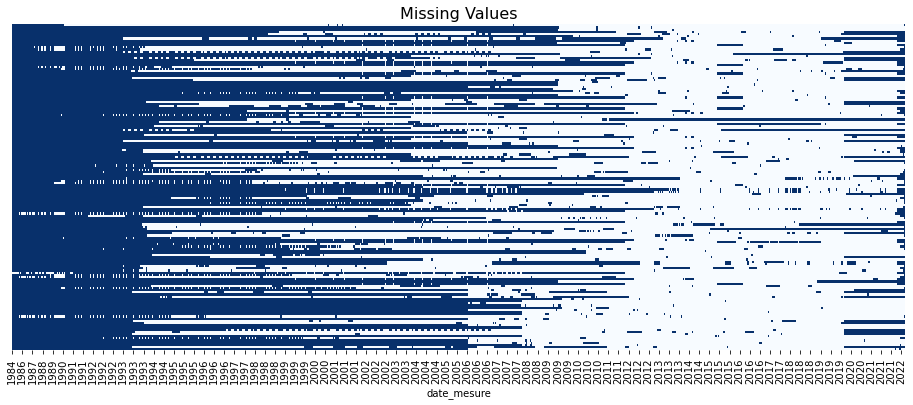

In [111]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [112]:
data_week = pd.DataFrame(data.resample('7D', origin ="start_day").mean())

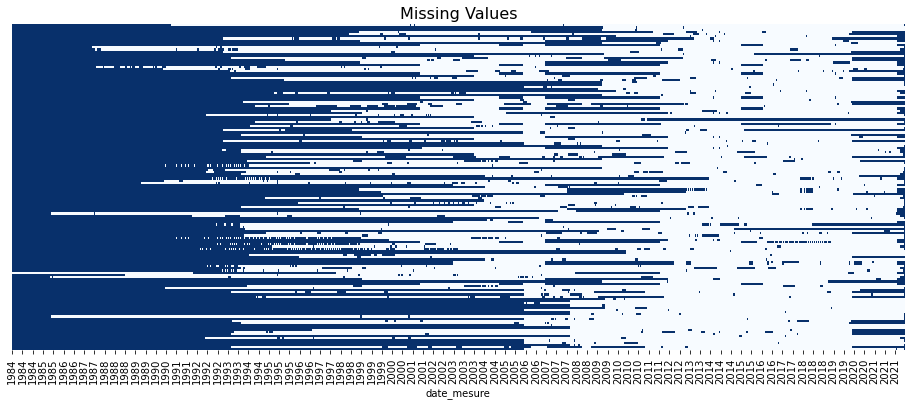

In [113]:
f_plot_nan(data_week)

In [114]:
data_week.shape

(2000, 149)

## Choix de la date de début pour avoir le plus de données possibles sur 8 ans consécutifs

La plage de temps minimale est fixée à 8 ans. La date de début et de fin correspondent à des dates où un maximum de piezos n'ont pas de valeur manquante.

85% des chroniques ont été conservées.
Date de début : 2011-12-07.
Date de fin : 2020-02-12.


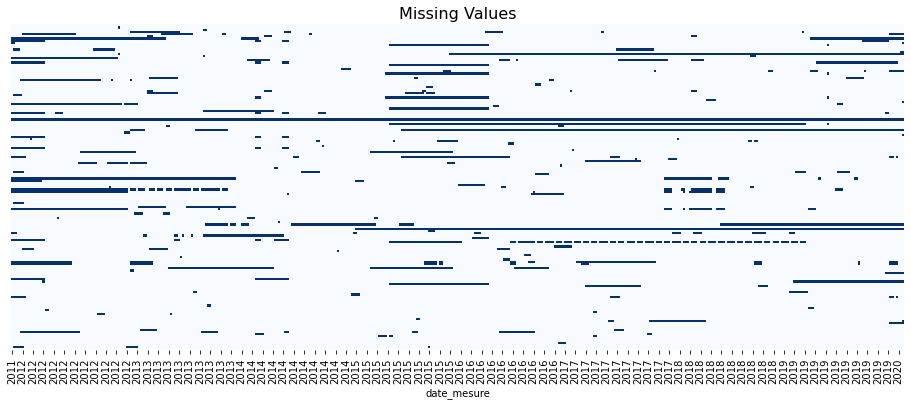

In [122]:
num_years = 0.0
pourcentage_NaN = 0.0

# Minimum de 8 ans d'intervalle
# Si une date n'est pas calculable, num_years sera égal à NaN et la boucle s'arrête, ce qui n'est pas bon.
# Comme NaN n'est jamais égal à NaN, la condition d'arrêt n'est pas bonne si num_years n'est égal elle même et possède donc une valeur

while num_years < 8 or num_years != num_years :
    pourcentage_NaN += 0.01
    date_init = data_week[(data_week.isnull().sum(axis=1)/data_week.shape[1] < pourcentage_NaN) == True].index.min()
    date_fin = data_week[(data_week.isnull().sum(axis=1)/data_week.shape[1] < pourcentage_NaN) == True].index.max()
    num_years = (date_fin - date_init).days / 365.2425

print(f"{int(100*(1-pourcentage_NaN))}% des chroniques ont été conservées.")
print(f"Date de début : {date_init.strftime('%Y-%m-%d')}.")
print(f"Date de fin : {date_fin.strftime('%Y-%m-%d')}.")

data_week_from_ = data_week.loc[date_init:date_fin]
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


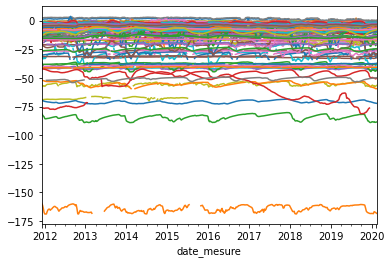

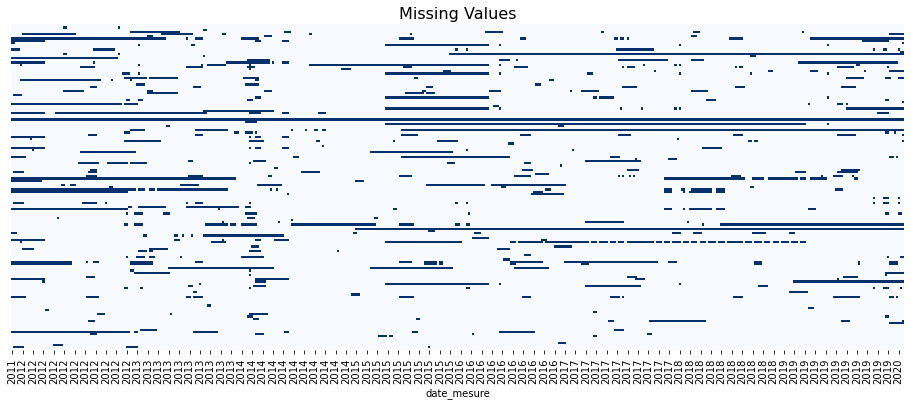

In [123]:
data_wo_outliers = data_week_from_.copy()
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()
f_plot_nan(data_wo_outliers)

## Suppression des piezos avec plus de 10 valeurs manquantes consécutives

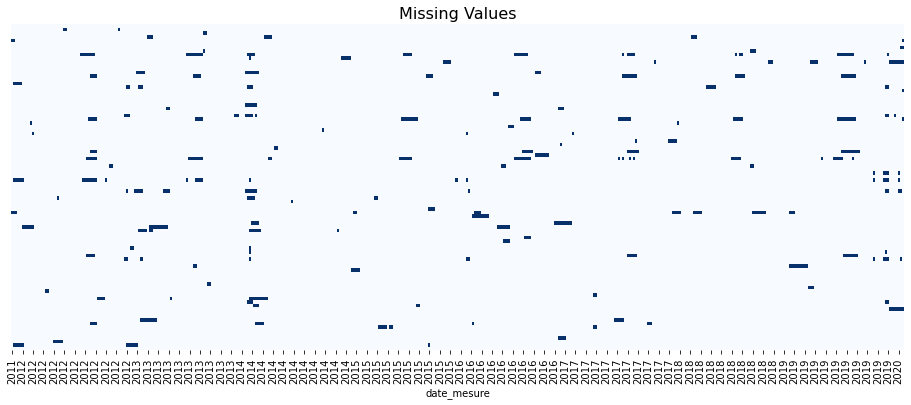

Il reste 91 piezos à analyser après filtrage.


In [124]:
max_consec_nan = 10
bss_to_drop = []

for piezo in data_wo_outliers :

    compteur = 0
    for date in data_wo_outliers.index :
        if pd.isnull(data_wo_outliers.loc[date,piezo]):
            compteur += 1

        else : compteur = 0
        if compteur == max_consec_nan:
            bss_to_drop.append(piezo)
            break

data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

f_plot_nan(data_clean)

print(f"Il reste {data_clean.shape[1]} piezos à analyser après filtrage.")

##Suppression des piezos avec plus de 5% de valeurs manquantes consécutives

#Liste des piezos avec plus de 10% de valeurs manquantes

bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

f_plot_nan(data_clean)

print(f"{data_clean.shape[1]} piezos de conservé après filtrage.")

## Interpolation

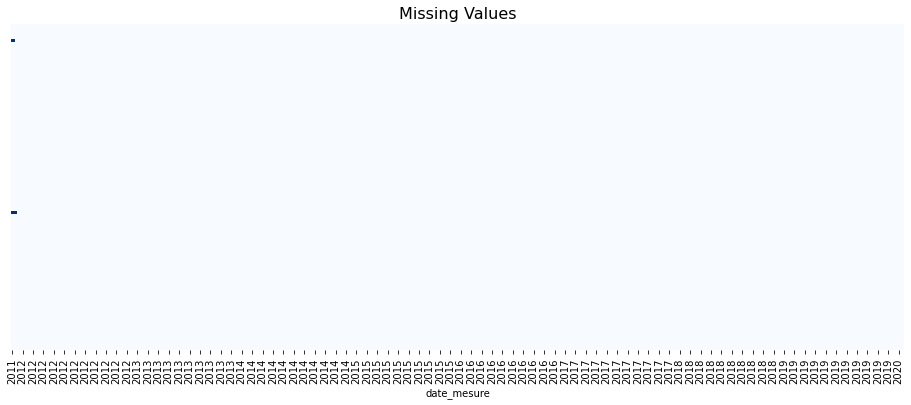

In [125]:
data_interpol = data_clean.copy().interpolate('linear')
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [131]:
debut = []
fin = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
    fin.append(data_interpol[f"{column}"].last_valid_index()) 
# date_debut = plus grande date en partant du début où il n'y a plus de Nan. Inversement pour date_fin    
date_debut = max(debut)
date_fin = min(fin)
data_interpol = data_interpol.loc[date_debut:date_fin]
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")
print(f"Il y a {data_interpol.shape[1]} chroniques pour le clustering.")

Nombre total de Nan : 0
Il y a 91 chroniques pour le clustering.


## Affichage des chroniques après nettoyage

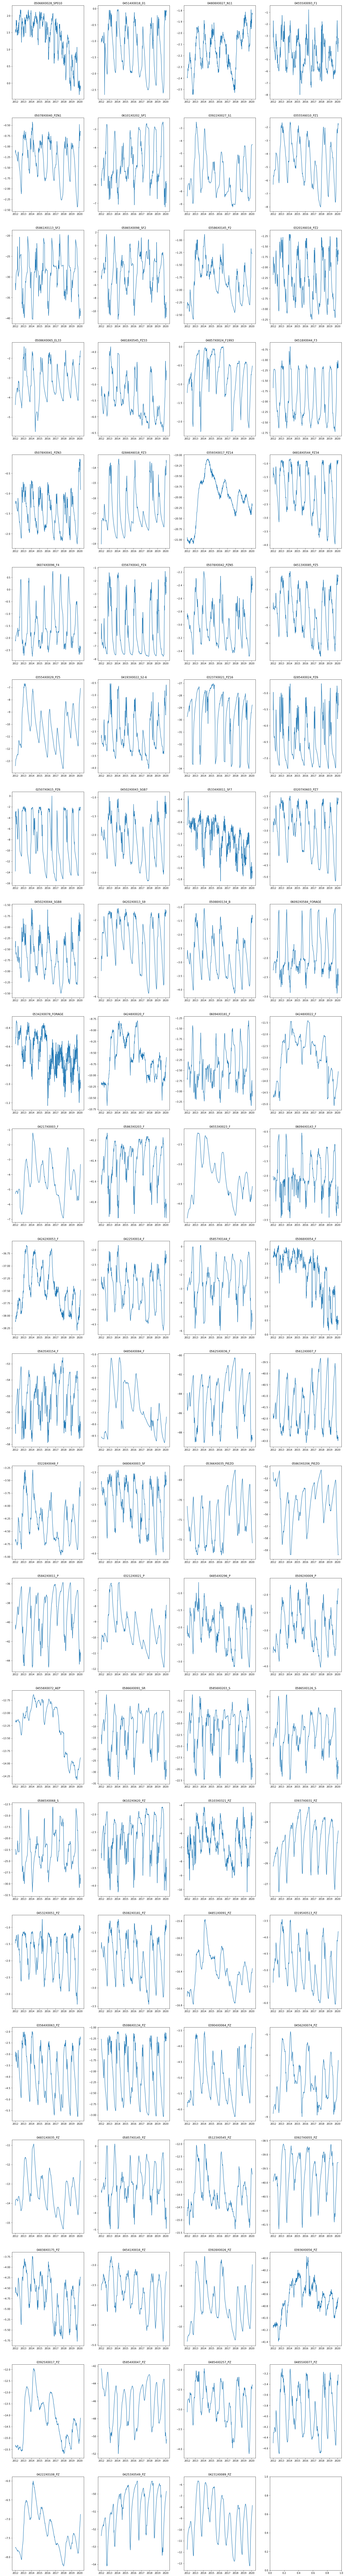

In [132]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [133]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

data_norm.head()

,05068X0028_SP010,04514X0018_01,04808X0027_N11,04555X0093_F1,05078X0040_PZN1,06101X0202_SP1,03922X0027_S1,03555X6010_PZ1,05861X0113_SF2,05865X0098_SF2,...,04541X0016_PZ,03928X0026_PZ,03936X0056_PZ,03925X0017_PZ,05854X0047_PZ,04854X0257_PZ,04855X0077_PZ,04222X0108_PZ,04253X0549_PZ,04231X0089_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2011-12-28,0.251025,0.276244,-1.444227,1.141110,0.378150,-0.806538,-1.046283,-1.126418,-0.435973,-0.169846,...,0.082147,-1.707661,-1.595901,-1.145426,1.759292,-0.469825,-1.360010,-0.814233,-1.372527,-1.356009
2012-01-04,0.394238,0.447998,-1.504479,2.225905,0.497627,-1.150876,-0.912244,-0.886748,-0.781697,-0.321756,...,0.332223,-1.656180,-1.732540,-1.157021,1.696158,-0.032925,-1.112382,-0.830470,-1.285400,-1.167264
2012-01-11,0.328315,0.336863,-1.306510,1.637111,0.426587,-0.773334,-0.752118,-0.748783,-0.659890,-0.342471,...,0.395534,-1.573539,-1.606022,-1.204850,1.608020,0.117836,-0.929919,-0.814233,-1.198273,-0.947310
2012-01-18,0.364686,0.308574,-1.263473,0.938953,0.320025,-0.657735,-0.629774,-0.708101,-0.387190,-0.157515,...,0.424023,-1.515284,-1.580719,-1.194704,1.511131,0.157834,-0.910370,-0.838589,-1.111146,-0.795719
2012-01-25,0.280577,0.332822,-1.005252,0.813020,0.307109,-0.586408,-0.551510,-0.752321,-0.163575,-0.065777,...,0.430354,-1.473286,-1.565537,-1.172964,1.394865,0.194755,-0.910370,-0.852120,-1.080768,-0.690944


## Sauvegarde du dataframe en csv

In [134]:
data_norm.to_csv(f"../Clustering/data/{region}.csv", sep = ";")